In [27]:
!pip install transformers[sentencepiece] -q 
!pip install datasets
!pip install tensorflow

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0


In [1]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [2]:
import pandas as pd
from datasets import load_dataset
dataset = load_dataset("tweet_eval", "emotion")

C:\Users\amitk\.conda\envs\DataScience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset tweet_eval (C:/Users/amitk/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 136.37it/s]


##### The above code will download the dataset named “tweet_eval” with the task/sub-category “emotion”. We can print and check the dataset,



In [3]:
# Print and check some details about the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})


##### Our dataset is the type of DatasetDict and has the train, validation and test split defined. We can directly access the training set of the dataset as follows,

In [4]:
# Select the training set from the dataset
train_ds = dataset['train']
print(train_ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 3257
})


##### When we print the training dataset, we can observe that it has two features, i.e. text and label. It also has information about the total number of samples in the dataset. We can find more details about the features by,

In [5]:
# More details about the features
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}


##### Here we can see that the text feature is of the type String and the label feature is ClassLabel. The ClassLabel type shows the total number of classes and their names, i.e. 4 in our example.

##### We can easily explore the dataset if it is Pandas Dataframe type. This can be done as follows,

In [6]:
# Convert the dataset to pandas dataframe
import pandas as pd
##########################################################
dataset.set_format("pandas")
train_df = pd.DataFrame(dataset["train"][:])

##### Now we can easily do basic checks like finding null values and the frequency of labels.  Now let's check for null values in the data frame,

In [7]:
# Check for null values 
train_df.isnull().sum()

text     0
label    0
dtype: int64

##### Well, we don't have null values. Before we find the frequency of the labels, let's convert the integers to corresponding label names in the dataframe.

In [8]:
#  Function to convert integer to string 
def label_int2str(x):
    return dataset["train"].features["label"].int2str(x)

In [9]:
# Add a label name 
train_df['label_name'] = train_df["label"].apply(label_int2str)

##### Now let's check the distribution of the labels,

In [10]:
# Let's check the distribution of different labels 
import matplotlib.pyplot as plt

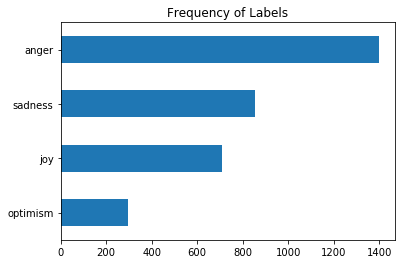

In [11]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Labels")
plt.show()

##### From the above graph, we can see that our dataset is heavily imbalanced. We can further do processing and data analysis from the data frame, but let’s convert it back to the Dataset type suitable for HuggingFace tokenisers and models.

In [12]:
# reset the format
dataset.reset_format()

## Tokenisation

Tokenisation is the most essential preprocessing step in natural language processing. It is converting unstructured text data into a numerical array based on the mapping present in the text vocabulary. Tokenisation is done as follows:

- Find a list of all unique words in the dataset
- Associate each word/token with a unique number. This is called vocab.
- Encode the dataset using the mapping present in the vocab.

There are different ways to perform tokenisation. Some of the prominent ones are:

- Word-based tokeniser
- Character-based tokeniser
- Sub-word based tokeniser

HuggingFace uses the sub-word based tokeniser to tokenise the datasets by default. Let’s see how to tokenise our dataset using HuggingFace’s AutoTokenizer class.

The most important thing to remember while using HuggingFace Library is: 

Always use the tokenizer and model belonging to the same model checkpoint while fine-tuning models for custom tasks. This will ensure that both model and tokenizer have the same knowledge about the tokens and their encodings.

We are using the Distill-Bert model to fine-tune the tweets_eval dataset. More information about the model can be found in the model card (https://huggingface.co/distilbert-base-uncased). We can access the tokeniser and model weights by using the HuggingFace library just by specifying the model name.

Now let’s download and import the tokeniser using the AutoTokenizer module,

In [13]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_ckpt)

##### HuggingFace will automatically download and cache the tokeniser locally. Now let's see how the tokeniser works with an example,

In [14]:
text = "This is an example of tokenization"
output = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
print(f"Tokenized output: {output}")
print(f"Tokenized tokens: {tokens}")
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized output: {'input_ids': [101, 2023, 2003, 2019, 2742, 1997, 19204, 3989, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
Tokenized tokens: ['[CLS]', 'this', 'is', 'an', 'example', 'of', 'token', '##ization', '[SEP]']
Tokenized text: [CLS] this is an example of tokenization [SEP]


##### Let’s check some important information about the tokeniser like voacb_size, model_max_length etc.,

In [15]:
print(f"Vocab size is : {tokenizer.vocab_size}")
print(f"Model max length is : {tokenizer.model_max_length}")
print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 30522
Model max length is : 512
Model input names are: ['input_ids', 'attention_mask']


Model max length defines the maximum number of tokens that a single data sample can have, i.e. in the above case, our model DistilBert can accept text sequences of up to 512 tokens long. Model input names are the fields that the model will take as inputs for training and inference purposes.

Since we have seen how the tokeniser works, let’s now tokenise the entire dataset.

In [16]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
# Tokenize entire dataset 
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\amitk\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-587858c733976373.arrow
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27ba/s]
Loading cached processed dataset at C:\Users\amitk\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-441ea9415f78ee06.arrow


Great! We can print the dataset and check that extra fields, i.e. input_ids and attention_mask have been added. Now we are ready for the final step, i.e. training the text classifier.

### Training the Text Classifier
Let’s start by importing the TFAutoModelForSequenceClassification method from the transformers library. This will automatically download and cache the model provided with the checkpoint name. Since we have defined the checkpoint while downloading the tokeniser, we should also use the same to download the model.

In [17]:
from transformers import TFAutoModelForSequenceClassification
num_labels = 4
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                             num_labels=num_labels)

C:\Users\amitk\.conda\envs\DataScience\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
C:\Users\amitk\.conda\envs\DataScience\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\amitk\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: http

We have installed the pre-trained DistilBert Model along with the newly attached model head; thus, this model can now be trained for classification tasks with 4 output labels. Now let’s prepare our data to train it with our model using the Tensorflow deep learning framework.

Before we feed the processed token ids into the model, we need to ensure that the dataset is provided as batches and that each data set has an equal length. To do this, HuggingFace gives us a DataCollator method that automatically performs padding to every sample in a batch. The size of every input data sample is equal to the length of the sample with maximum length.

In [18]:
batch_size=64
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

##### Now let’s create the TensorFlow datasets from the tokenised dataset,

In [24]:
tokenized_dataset["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3257
})

In [27]:
# Create tf datasets 
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=["input_ids"], 
    label_cols=["label"], 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["validation"].to_tf_dataset(
    columns=["input_ids"], 
    label_cols=["label"], 
    shuffle=False, 
    batch_size=batch_size,
    collate_fn=data_collator
)

In [20]:
# Imports
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

In [22]:
# Compile the model with Adam optimiser, SparseCategoricalCrossEntropy loss function
# and SparseCategoricalAccuracy as the metric.

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics.SparseCategoricalAccuracy()
)

In [28]:
# Now finally, let’s fit the model for 5 epochs,

# Fit the model
model.fit(tf_train_dataset, 
          validation_data=tf_valid_dataset, 
          epochs=5)

Epoch 1/5
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
51/51 [==============================] - 270s 5s/step - loss: 1.1296 - sparse_categorical_accuracy: 0.5177 - val_loss: 0.7826 - val_sparse_categorical_accuracy: 0.7032
Epoch 2/5
51/51 [==============================] - 261s 5s/step - loss: 0.6071 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.7567
Epoch 3/5
51/51 [==============================] - 276s 5s/step - loss: 0.3533 - sparse_categorical_accuracy: 0.8898 - val_loss: 0.7307 - val_sparse_categorical_accuracy: 0.7460
Epoch 4/5
51/51 [==============================] - 286s 6s/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.7861
Epoch 5/5
51/51 [==============================] - 276s 5s/step - loss: 0.1258 - sparse

In [29]:
# Great! Now we have trained our model for 5 epochs. Now let’s test the model on some sentences.

outputs = model.predict(tokenizer("I feeling very happy")["input_ids"])
outputs['logits'][0].tolist()

1/1 [==============================] - 2s 2s/step


[-1.8213118314743042,
 3.556459903717041,
 -1.7373497486114502,
 -0.2650727927684784]

In [30]:
# We have fed the model a sentence in the above code, i.e. I am feeling thrilled. We can observe that this sentence belongs to the emotion of joy. Now let’s check the model prediction,

# Apply softmax and pick the label with maximum probability
import numpy as np
label_int = np.argmax(tf.keras.layers.Softmax()(outputs['logits'][0].tolist()))
print(label_int.item())

1


Since the model outputs just the logits, we need to apply softmax activation to convert the values into probabilities. We use softmax and not sigmoid activation because softmax converts logits of multiple classes into the range 0 to 1, therefore suitable for multi-class classification. Now we got the index of maximum probability, and let’s check which type it corresponds to.


In [31]:
print(label_int2str(label_int.item()))

joy


Great! Its joy. Our model quickly picked up the sentiment of the sentence. Now we can further improve this model by training for more epochs or preparing better validation sets etc. Then finally, deploy the model in production settings.

# Conclusion on Text Classifier
In this session, we have seen how to train a state-of-the-art text classifier by fine-tuning the pre-trained models from HuggingFace Hub. Pre-trained models made publicly available as a part of HuggingFace Hub are a treasure to the machine learning community. As seen above, we can quickly load and train on our datasets instead of training from scratch, which forms the basis for Transfer Learning. Through the number of models and resources available, we can experiment and create new models that might someday revolutionise the world.